In [1]:
import xarray as xr
import numpy as np

from matplotlib import pyplot as plt, animation


Loads gridded monthly sea ice data from NOAA NCEI dataset

In [12]:
ds = xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/icec.mon.mean.nc',
                    chunks={'time':50})
sic_mon = ds['icec']

arctic_data = sic_mon.where(sic_mon['lat'] > 45, drop=True)
arctic_data = arctic_data.sel(time=~arctic_data['time'].dt.year.isin([2023]))
annual_means = arctic_data.groupby('time.year').mean(dim='time')
annual_means.to_netcdf('siconc_ann_NOAA_OISST.nc')

In [20]:
annual_means[0,:,:].plot()

KeyboardInterrupt: 

In [13]:
import numpy as np
from scipy.stats import linregress

def calculate_trend(da):
    time_len = annual_means['year'].size
    slope, intercept, r_value, p_value, std_err = linregress(np.arange(time_len), da)
    return xr.DataArray(slope, attrs={'p_value': p_value})

trends = annual_means.groupby('year').apply(calculate_trend)


KeyboardInterrupt: 

Text(0.5, 1.0, 'Bering Strait heat flux (PW)')

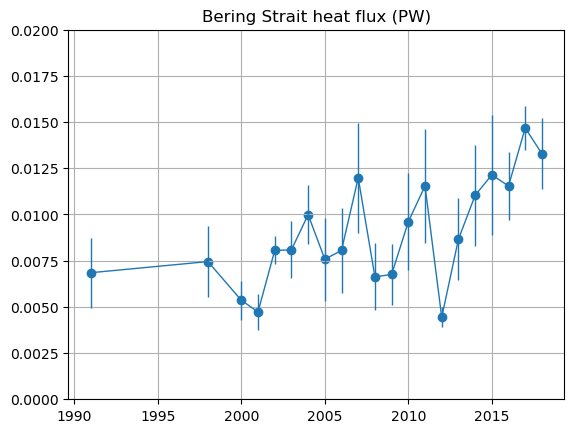

In [11]:
# from Woodgate moorings
#
# format [yr,  heat, error] 
# units: 1e20 J/yr 
oht_ann = np.array([[1991, 2.16, 1.20], 
                   [1998, 2.35, 1.20], 
                   [2000, 1.69, 0.67],
                   [2001, 1.49, 0.61], 
                   [2002, 2.54, 0.48],
                   [2003, 2.55, 0.97],
                   [2004, 3.15, 1.00],
                   [2005, 2.39, 1.41],
                   [2006, 2.54, 1.45],
                   [2007, 3.78, 1.88],
                   [2008, 2.09, 1.14],
                   [2009, 2.13, 1.05],
                   [2010, 3.03, 1.65],
                   [2011, 3.64, 1.95],
                   [2012, 1.40, 0.34],
                   [2013, 2.73, 1.40],
                   [2014, 3.48, 1.72],
                   [2015, 3.83, 2.04],
                   [2016, 3.64, 1.15],
                   [2017, 4.63, 0.76],
                   [2018, 4.19, 1.21]])

# convert the units to PW 
s_per_yr = 31536000
oht_ann[:,1:] *= (1/s_per_yr * 1e20 / 1e15)

plt.errorbar(oht_ann[:,0], oht_ann[:,1], yerr=oht_ann[:,2]/2, linewidth=1)
plt.scatter(oht_ann[:,0], oht_ann[:,1])
plt.ylim([0,0.02])
plt.grid()
plt.title("Bering Strait heat flux (PW)")


In [81]:
# retrieve sea ice north of 45N
sic_mon_45N = sic_mon.icec[:,600:,:].to_numpy()

In [157]:
# convert sea ice conc to annual mean 
# a rather naive way to calculate weighted annual mean since xarray not working
def annmean(data): 
    # days per month
    day_per_mon = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    assert day_per_mon.sum() == 365
    
    # calculate weights based on days
    weights = day_per_mon / 365
    assert np.isclose(weights.sum(), 1)
    
    yrs = (data.shape[0] // 12)
    
    # reshape data to (12, nyrs, nlat, nlon)
    data_reshaped = data.reshape(((12,-1) + data.shape[1:]))
    return np.average(data_reshaped, axis=0, weights=weights)

sic_ann = annmean(np.nan_to_num(sic_mon_45N[4:496,:,:]))

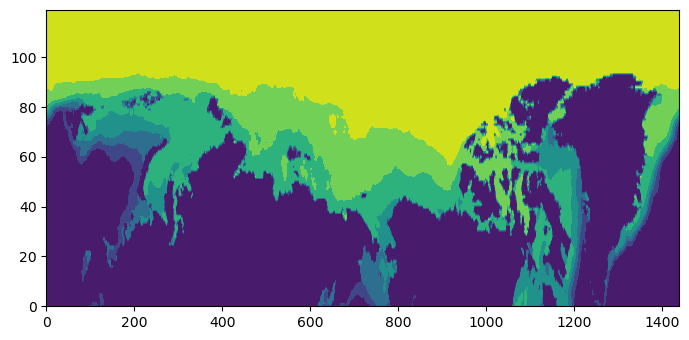

In [158]:
plt.contourf(sic_ann[0,:,:])

In [159]:
sic_mon.time[4:496]

<xarray.DataArray 'time' (time: 492)>
array(['1982-01-01T00:00:00.000000000', '1982-02-01T00:00:00.000000000',
       '1982-03-01T00:00:00.000000000', ..., '2022-10-01T00:00:00.000000000',
       '2022-11-01T00:00:00.000000000', '2022-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2022-12-01
Attributes:
    long_name:     Time
    delta_t:       0000-01-00 00:00:00
    avg_period:    0000-01-00 00:00:00
    axis:          T
    actual_range:  [66352. 81508.]
    _ChunkSizes:   512